# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"
signnames_file = "signnames.csv"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(signnames_file, mode='r') as f:
    signnames = []
    reader = csv.DictReader(f, delimiter=',')
    for row in reader:
        signnames.append(row['SignName'])
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_test[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

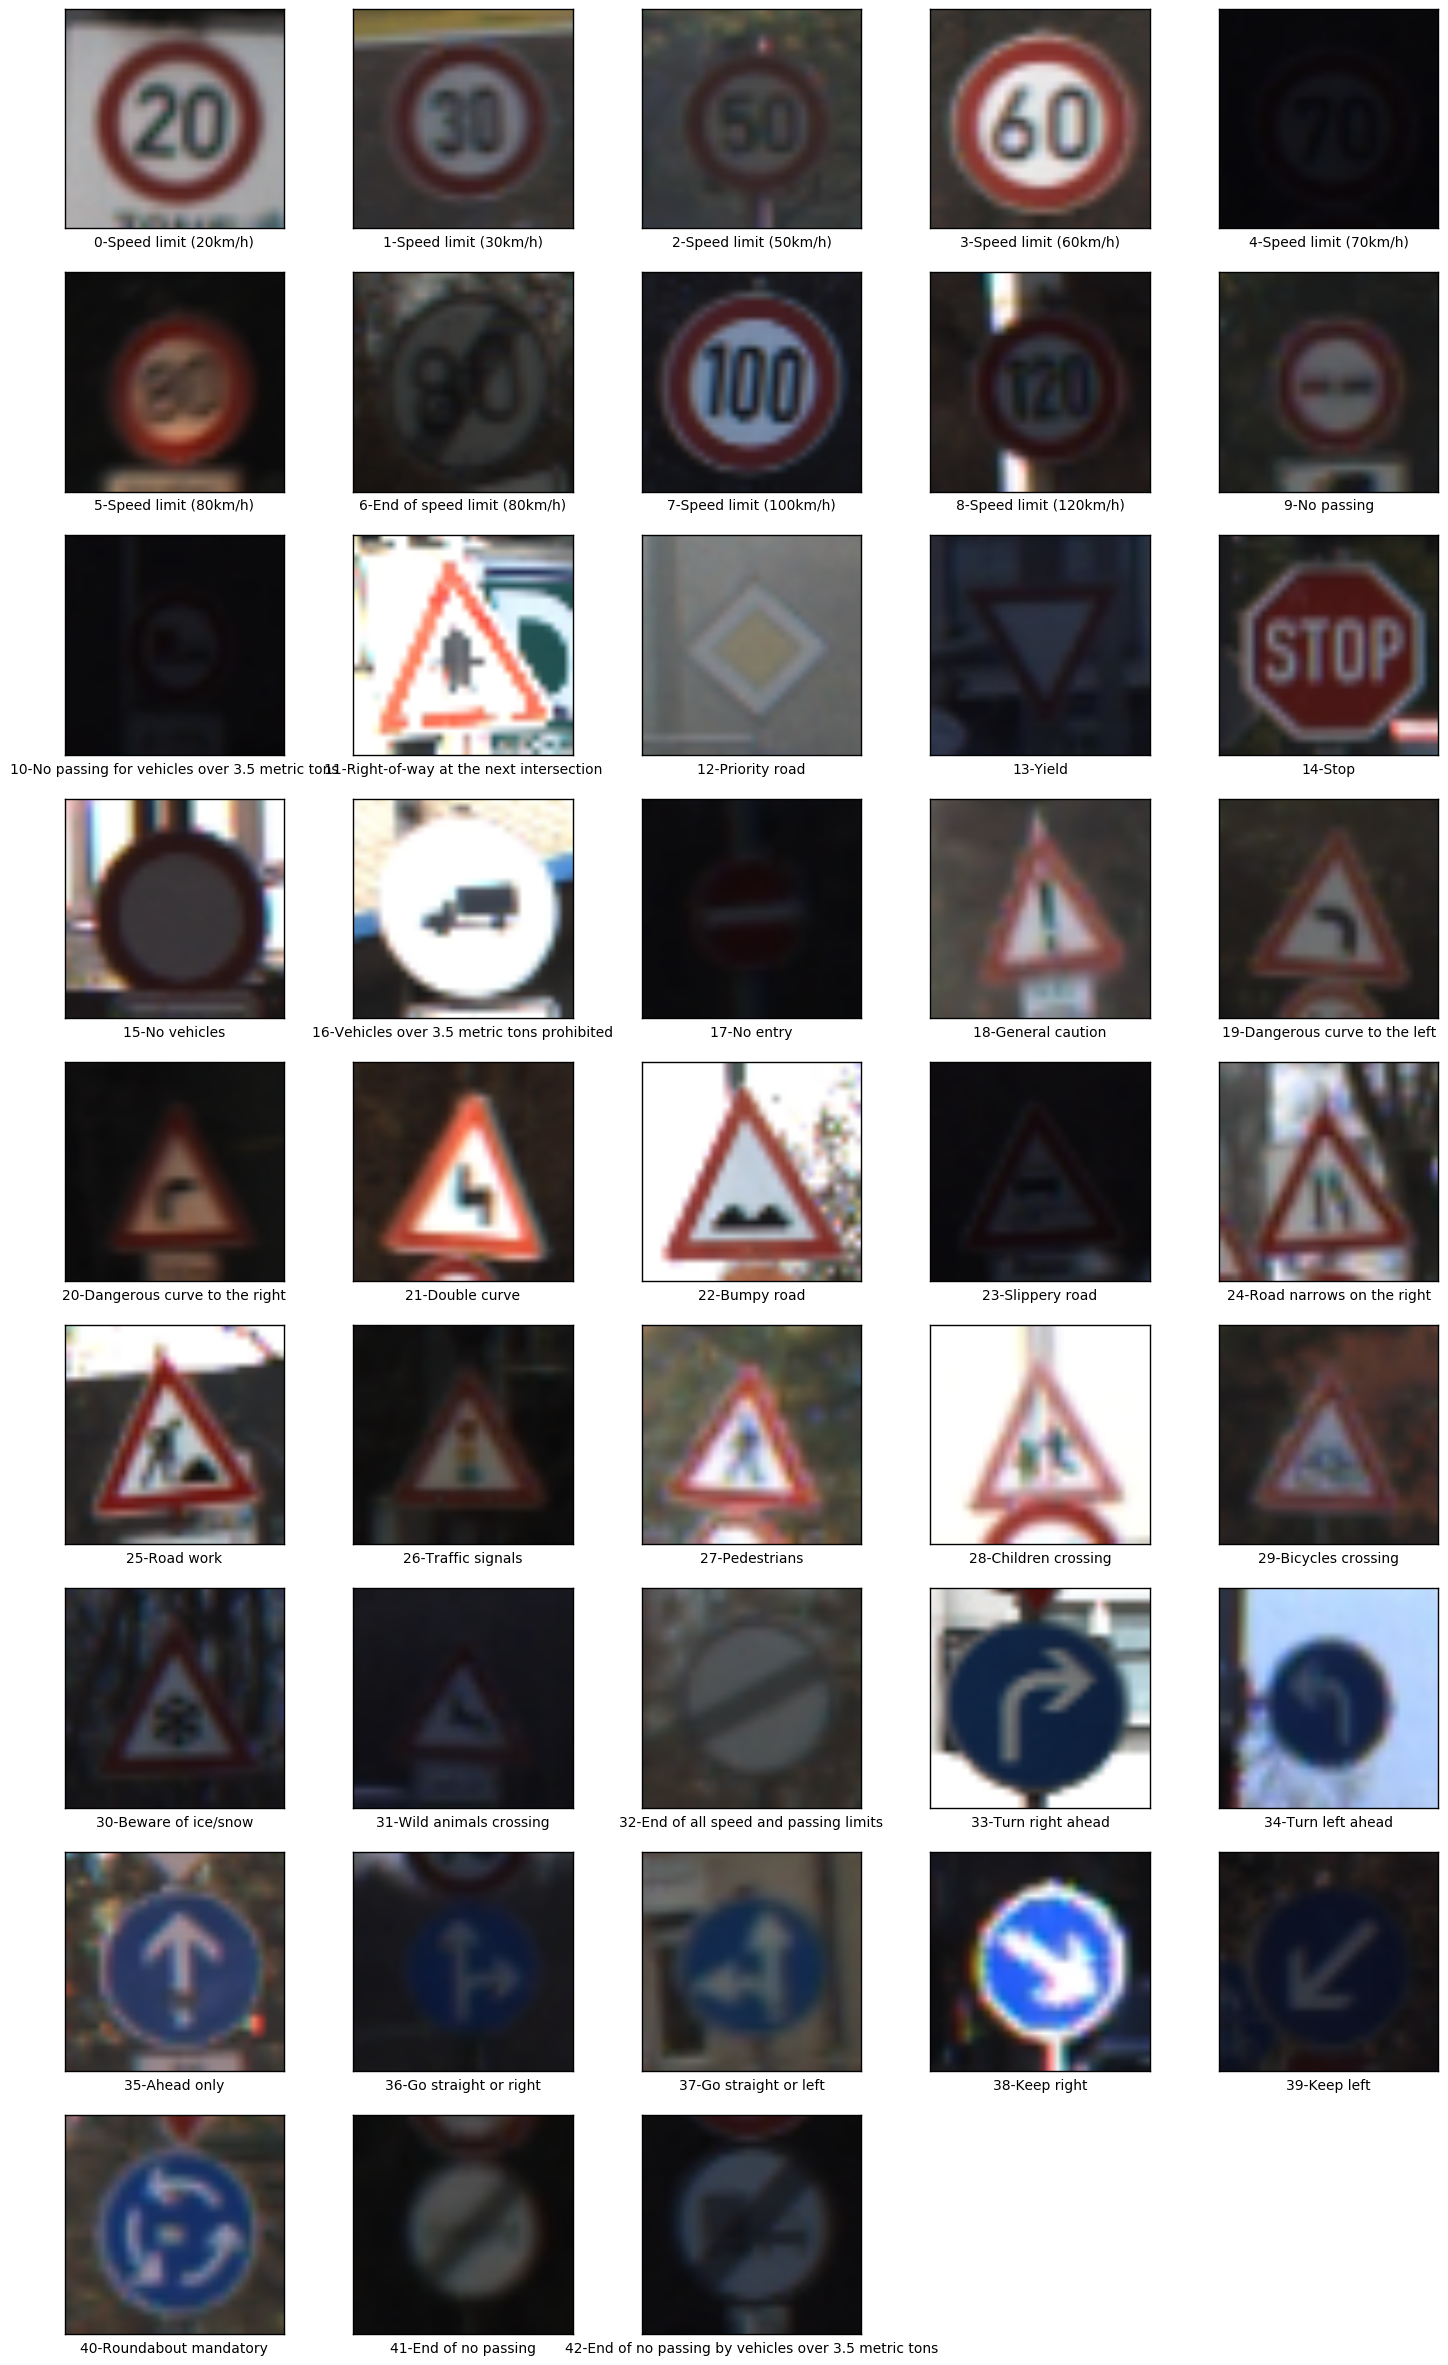

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import math

# Visualizations will be shown in the notebook.
%matplotlib inline

def plot_image_classes():
    unique_labels = list(range(0,43))

    cols = 5
    rows = math.ceil(len(unique_labels)/cols)

    fig, axes = plt.subplots(rows, cols, figsize=(18, 30))

    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    while unique_labels:
        i = unique_labels.pop()
        ax = axes[i//cols][i%cols]
        labels_subset = [j for j,l in enumerate(y_train) if l==i]
        ax.imshow(X_train[labels_subset[int(len(labels_subset)*random.random())]])
        ax.set_xlabel("{}-{}".format(i, signnames[i]))

    for ax in axes.flat:
        if ax.get_xlabel():
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)
            
    plt.show()
    
plot_image_classes()


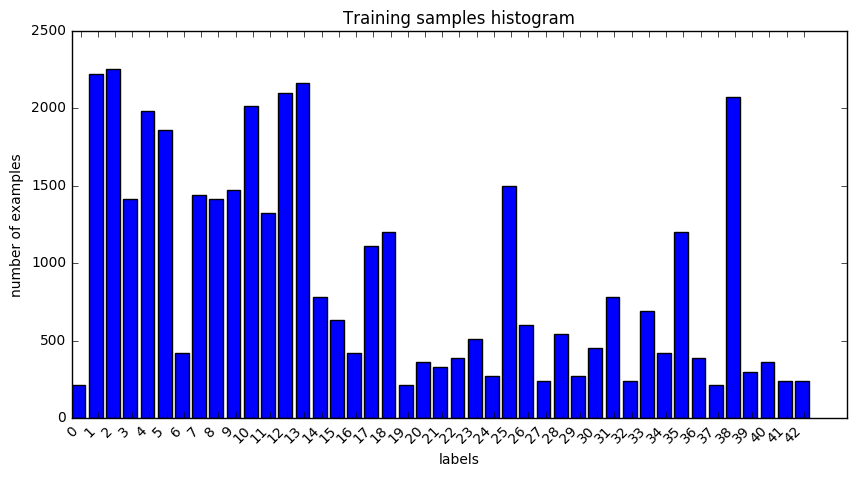

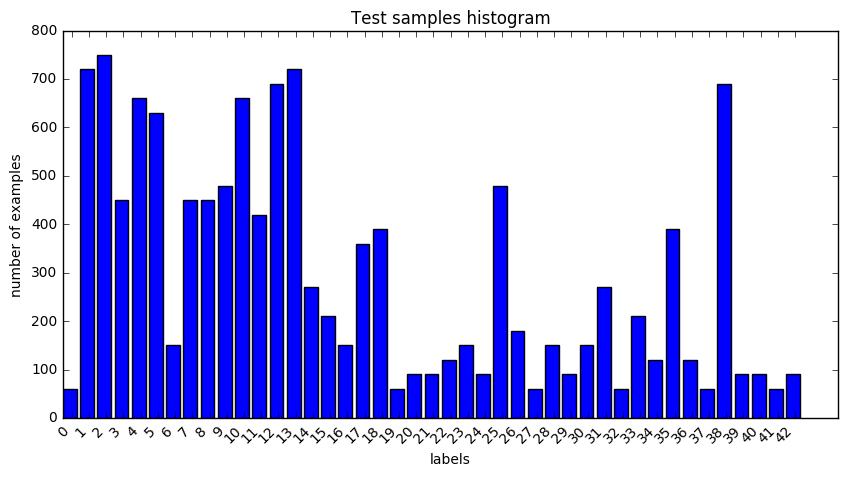

In [4]:
def plot_class_frequencies(labels, title): 
    unique_labels = list(range(0,43))
    class_frequency = [0]*len(unique_labels)
    for l in labels:
        class_frequency[l] = class_frequency[l] + 1            
 
    fig, ax = plt.subplots(figsize=(10, 5))

    bars = plt.bar(range(n_classes), class_frequency, width=0.8, label=unique_labels)
    xticks_pos = [0.65*b.get_width() + b.get_xy()[0] for b in bars]
    plt.xticks(xticks_pos, unique_labels,  ha='right', rotation=45)
    plt.ylabel('number of examples')
    plt.xlabel('labels')    
    plt.title(title)

    plt.show()

# Plot the histograms for both the training set and the test set to visualize whether there are skewed classes and
# whether each class is represented moreless equally in both data sets.

plot_class_frequencies(y_train, 'Training samples histogram')
plot_class_frequencies(y_test, 'Test samples histogram')

 Since the dataset has skewed classes, precision and recall migh be a better metric than accuracy to 
 determining the quality of the model. We'll use the standard accuracy (as taught in the course lessons and labs)
 along with the F1 score (2 * ((P * R)/ (P + R))). We'll also create a confusion matrix.

 In any case, the test dataset is a good data set because it reflects the frecuencies of the training dataset
 (but we shall not look into the test set until the model is set in stone). 

 When we randomly sample the training set to create the training and validation sets, we should get similar frequencies.
 In the case we don't, we should switch to stratified sampling instead of random sampling.
 We assume that these frecuencies represent the real world occurences of the signals. If that were not the case,
 we ought to over sample minority classes (by creating synthetic samples for minority classes)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import numpy as np
import cv2

def show_images(images, n_images):
    
    n = min(len(images), n_images)

    fig, axes = plt.subplots(n//10, 10, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])        
        ax.set_xticks([])
        ax.set_yticks([])

        
    plt.show()

def equalize_image(image):
    
    # READ RGB color image and convert it to Lab
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)

    # Extract the L channel
    l_channel,a_channel,b_channel = cv2.split(lab_image)

    # apply the CLAHE algorithm to the L channel
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
    clahed_l_channel = clahe.apply(l_channel);

    # Merge the the color planes back into an Lab image
    lab_image = cv2.merge((clahed_l_channel, a_channel, b_channel));
    # convert back to RGB
    image_clahe = cv2.cvtColor(lab_image, cv2.COLOR_Lab2RGB);
    
    return image_clahe

def normalize_image(image):
    return (np.float32(image/255.0))

def pre_process_images(images):    
    pre_processed_images = np.zeros(images.shape, dtype=np.float32)
    
    for i in range(images.shape[0]):
        image_clahe = equalize_image(images[i])        
        pre_processed_images[i] = normalize_image(image_clahe)
    return pre_processed_images




Original images


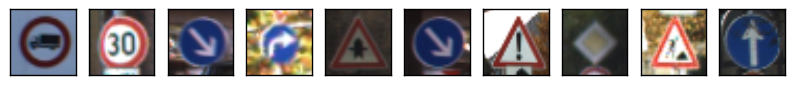

Pre-Processed images


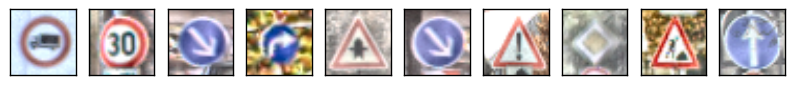

In [7]:
# Plot pre-processed images to check the result. Use the test dataset because images are not ordered.
print('Original images')
show_images(X_test[0:10], 10)
print('Pre-Processed images')
show_images(pre_process_images(X_test[0:10]), 10)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
After visualizing image samples, I concluded that there is a high contrast variation among images in the dataset. I have found that applying contrast normalization is necessary in this case. According to the paper "A Committee of Neural Networks for Traffic Sign Classification" (http://people.idsia.ch/~juergen/ijcnn2011.pdf), Contrast-limited Adaptive
Histogram Equalization (CLAHE) performs best compared to other types of normalization.
After aplying CLAHE, I scaled images between 0. and 1. by dividing by 255. I keep 3 channels for color information, as training with color images performed better than greyscale, although the latter was also shown to be competitive and less computationally demanding.

Transformed images


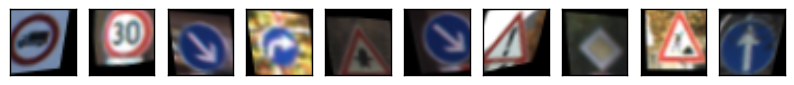

Transformed and pre-processed images


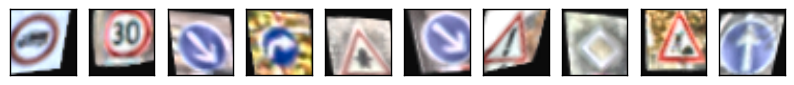

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
def transform_translate(image, translation_factor):
    translation_range_x = translation_factor*image.shape[1]
    translation_range_y = translation_factor*image.shape[0]
    translate_x = np.random.uniform(low=(-translation_range_x), high=(translation_range_x))
    translate_y = np.random.uniform(low=(-translation_range_y), high=(translation_range_y))
    M = np.float32([[1,0,translate_x], [0,1,translate_y]])
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

def transform_rotate(image, rotation_range):
    # Rotation angle range is in degrees
    rotation_angle = np.random.uniform(low=(-rotation_range), high=(rotation_range))
    M = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), rotation_angle, 1)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

def transform_shear(image, shear_range):
    # Shear angle range is in degrees
    shear_rad = math.radians(shear_range)
    shear_x = np.random.uniform(low=(-shear_rad), high=(shear_rad))
    shear_y = np.random.uniform(low=(-shear_rad), high=(shear_rad))
    M = np.array([[1., -math.tan(shear_x), 0.],
                  [-math.tan(shear_y), 1., 0.]])
                  
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

def transform_image(image, rotation_range, translation_factor, shear_range):
    t_image = transform_rotate(image, rotation_range)
    t_image = transform_translate(t_image, translation_factor)
    t_image = transform_shear(t_image, shear_range)
    
    return t_image
    
X_transformed = np.zeros_like(X_test[0:10])
for i in range(10):
    X_transformed[i] = transform_image(X_test[i], 10, 0.1, 15)

print('Transformed images')
show_images(X_transformed[0:10], 10)

print('Transformed and pre-processed images')
X_transformed = pre_process_images(X_transformed[0:10])
show_images(X_transformed[0:10], 10)

In [7]:
rotation_range = 10 # rotation range from -10 to 10 degrees
translation_factor = 0.1 # translation within 10% of the image size in any direction
shear_range = 15 # shear angle range from -15 to 15 degrees

def augment_data(X_dataset, y_dataset, n_transforms = 5):    
    X_aug = []
    y_aug = []
    for i in range(len(X_dataset)):
        X_aug.append(X_dataset[i])
        y_aug.append(y_dataset[i])
        for i_n in range(n_transforms):
            X_transformed = transform_image(X_dataset[i], rotation_range, translation_factor, shear_range)
            X_aug.append(X_transformed)
            y_aug.append(y_dataset[i])
            
    X_aug = np.array(X_aug, X_dataset.dtype)
    y_aug = np.array(y_aug, y_dataset.dtype) 
 
    return X_aug,y_aug

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

# split the data into training/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Augment training set
X_train, y_train = augment_data(X_train, y_train, 5)

# Shuffle training/validation sets
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

# preprocess all images
X_train = pre_process_images(X_train)
X_val   = pre_process_images(X_val)
X_test  = pre_process_images(X_test)

print('Training set: samples {}; labels {}'.format(X_train.shape[0], y_train.shape[0]))
print('Validation set: samples {}; labels {}'.format(X_val.shape[0], y_val.shape[0]))
print('Test set: samples {}; labels {}'.format(X_test.shape[0], y_test.shape[0]))

print('Number of classes: training {}; validation {}; test {}'.format(len(set(y_train)), 
                                                                      len(set(y_val)), len(set(y_test))))
# One-Hot encode labels
one_hot_encoder = LabelBinarizer()
one_hot_encoder.fit(y_train)
y_train = one_hot_encoder.transform(y_train).astype(np.float32)
y_val   = one_hot_encoder.transform(y_val).astype(np.float32)
y_test  = one_hot_encoder.transform(y_test).astype(np.float32)

print('Classes One-Hot Encoded')

Training set: samples 188202; labels 188202
Validation set: samples 7842; labels 7842
Test set: samples 12630; labels 12630
Number of classes: training 43; validation 43; test 43
Classes One-Hot Encoded


In [9]:
file_name = 'processed_data.bin'
print('Saving pre processed data to file...')
with open(file_name, 'wb') as f:
    np.save(f, X_train)
    np.save(f, y_train)
    np.save(f, X_val)
    np.save(f, y_val)
    np.save(f, X_test)
    np.save(f, y_test)


print('Saved.')

Saving pre processed data to file...
Saved.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I first split the original training data into the training and the validation set, using a 20% of the data for the validation. I use the train_test_split() from sklearn for that, which randomizes the datasets. Then I applied data augmentation on the training set. I purposely left the validation set untouched, as I use the validation set to try to estimate how the model works on real world data. 

<p>Labels were one-hot encoded.

I employed the data augmentation technique to artificially increase the size of the dataset in order to improve generalization and avoid overfitting, specially considering the reduced number of samples in some clases. It should also provide some degree of transformattion invariance. For each training sample I generated 5 new ones, leaving the proportion of each class unmodified. This multiplies by 6 the number of samples in each class. For each new sample I applied all the following transformations:
<ol>
 <li>Random rotations: from -10 to 10 degrees</li>
 <li>Random translation: 10% of the image size in any direction</li>
 <li>Random shearing: from -15 to 15 degrees in box axes</li>
</ol>

<p>The values for translation, rotation and scaling are drawn from uniform distributions in the specified ranges. I let OpenCV peform bilinear interpolation after each transformation. 

<p>This technique was inspired by the paper "A Committee of Neural Networks for Traffic Sign Classification" and by Vivek Yadav (https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.5jbv6jlr7). The aforementioned paper uses scaling instead of shearing, but since the training data set already contains the same sign with different scaling factors (as they look like an approaching sequence of images), I apply shear instead of scaling to simulate different viewing angles. The number of new samples was limited by the RAM memory in the system and that I found that at certain point more samples didn't improve the generalization power of my model.

<p> After augmenting the training data set, I applied the pre-processing steps explained before to all the datasets (training, validation and test), and one-hot encoded the class labels.

<p> Alternatively, a better technique would call for the augmentation to be performed before each training epoch, but it would have been very demanding computationally. I also discarded per-batch data augmentation as it would overrepresent certain signs and classes in each weight update. Thus, I opted to use the same agumented training data set in the whole training process.

In [193]:
import numpy as np

file_name = 'processed_data.bin'
print('Loading pre processed data file...')
with open(file_name, 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f)
    X_val = np.load(f)
    y_val = np.load(f)
    X_test = np.load(f)
    y_test = np.load(f)


print('Loaded.')

print('Training set shapes: samples {}; labels {}'.format(X_train.shape, y_train.shape))
print('Validation set shapes: samples {}; labels {}'.format(X_val.shape, y_val.shape))
print('Test set shapes: samples {}; labels {}'.format(X_test.shape, y_test.shape))

Loading pre processed data file...
Loaded.
Training set shapes: samples (188202, 32, 32, 3); labels (188202, 43)
Validation set shapes: samples (7842, 32, 32, 3); labels (7842, 43)
Test set shapes: samples (12630, 32, 32, 3); labels (12630, 43)


In [194]:
index_in_epoch = 0
epochs_completed = 0
def get_next_train_batch(batch_size):
    global index_in_epoch
    global epochs_completed
    global X_train
    global y_train
    
    num_samples = len(X_train)
    
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > num_samples:
        # Finished epoch
        epochs_completed += 1
        # Shuffle the data
        perm = np.arange(num_samples)
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        # Start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_samples
    end = index_in_epoch
    return X_train[start:end], y_train[start:end]

def get_num_train_samples():
    global X_train
    return len(X_train)

index_in_val_set = 0
def get_next_validation_batch(batch_size):
    global index_in_val_set
    global X_val
    global y_val
    
    num_samples = len(X_val)
    
    if index_in_val_set >= num_samples:
        index_in_val_set = 0
    
    start = index_in_val_set
    index_in_val_set += batch_size
    if index_in_val_set > num_samples:
         index_in_val_set = num_samples
    end = index_in_val_set
    return X_val[start:end], y_val[start:end]

def get_num_validation_samples():
    global X_val
    return len(X_val)    

index_in_test_set = 0
def get_next_test_batch(batch_size):
    global index_in_test_set
    global X_test
    global y_test
    
    num_samples = len(X_test)
    
    if index_in_test_set >= num_samples:
        index_in_test_set = 0
    
    start = index_in_test_set
    index_in_test_set += batch_size
    if index_in_test_set > num_samples:
         index_in_test_set = num_samples
    end = index_in_test_set
    return X_test[start:end], y_test[start:end]

def get_num_test_samples():
    global X_test
    return len(X_test)

def get_test_classes():
    global y_test
    return np.argmax(y_test, axis=1)
    

In [18]:
# Hyperparameters
learning_rate = 0.001
n_epochs = 15
batch_size = 256

In [19]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(length):
    initial = tf.constant(0.05, shape=[length])
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def cnn_model(x, keep_prob):
    
    # Layer 0: Input = 32x32x3
    #x0 = tf.reshape(x, [-1,32,32,3])
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x100
    conv1_W = weight_variable([3, 3, 3, 100])
    conv1_b = bias_variable(100)
    conv1 = conv2d(x, conv1_W) + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Max Pooling. Input = 32x32x100. Output = 16x16x100
    conv1 = max_pool_2x2(conv1)

    # Layer 2: Convolutional. Input = 16x16x100. Output = 16x16x150.
    conv2_W = weight_variable([3, 3, 100, 150])
    conv2_b = bias_variable(150)
    conv2 = conv2d(conv1, conv2_W) + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 16x16x150. Output = 8x8x150
    conv2 = max_pool_2x2(conv2)
    
    # Layer 3: Convolutional. Input = 8x8x150. Output = 8x8x250
    conv3_W = weight_variable([3, 3, 150, 250])
    conv3_b = bias_variable(250)
    conv3 = conv2d(conv2, conv3_W) + conv3_b
    # Activation.
    conv3 = tf.nn.relu(conv3)                          
    # Pooling. Input = 8x8x250. Output = 4x4x250.
    conv3 = max_pool_2x2(conv3)
                              
    # Flatten. Input = 4x4x250. Output = 4000
    fc0 = flatten(conv3)
    
    # Layer 4: Fully Connected. Input = 4000. Output = 200
    fc1_W = weight_variable([4000, 200])
    fc1_b = bias_variable(200)
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation
    fc1 = tf.nn.relu(fc1)    
    # Drop-Out
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 200. Output = 43
    fc2_W  = weight_variable([200, 43])
    fc2_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    return logits

tf.reset_default_graph()


# Placeholders for a batch of training samples
# Training images are 32x32x3
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
# Classify over 43 classes
y = tf.placeholder(tf.float32, (None, 43))
# Drop-Out rate
keep_prob = tf.placeholder(tf.float32)

logits = cnn_model(x, keep_prob)

# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Calculate accuracy
# y_pred contains the labels, not one-hot encoded
y_pred = tf.argmax(tf.nn.softmax(logits), 1)

correct_prediction = tf.equal(y_pred, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I have used a convolutional neural network with 3 convolutional layers and 2 fully connected layers. The input layer has three maps of 32x32 pixels, one for each color channel. The output layer has 43 neurons, one for each traffic sign class.
The architecture, sumarized in the table below, was vey similar to the one used in the paper "A Committee of Neural Networks for Traffic Sign Classification", but adapted to the image size of the provided dataset. 

<p>The first convolutional layer uses 100 filters with 3x3 kernels, to extract low-level features. The second convolutional layer uses 150 filters with 3x3 kernels, and the third convolutional layer uses 250 filters with 3x3 kernels, to extract higher level features. In each convolutional layer, a ReLU activation function is applied, followed by 2x2 max pooling. The output of the last convolutional layer is flattened to feed a fully connected layer of 200 neurons with ReLU activations. Dropout (with 50% of drop probabilty) is used in this layer to prevent the network from learning dependencies, and overfitting. Finally, the last fully connected layer has 43 neurons, one for each class, whose output are the logits.


 Layer  |    Type         | feature map size | Kernel
  ----- | --------------- | ---------------- | ------
   0    |      input      |     32x32x3      |
   1    |  convolutional  |    32x32x100     |  3x3
   1a   |  max pooling    |    16x16x100     |  2x2
   2    |  convolutional  |    16x16x150     |  3x3
   2a   |  max pooling    |     8x8x150      |  2x2
   3    |  convolutional  |     8x8x250      |  3x3
   3a   |   max pooling   |     4x4x250      |  2x2
   4    | fully connected |       200        |
   5    | fully connected |       43         |
   
The selected cost function is the mean of the of the cross entropy loss over all the samples in the batch.

In [25]:
save_file_name = 'trained_model.ckpt'
saver = tf.train.Saver()

In [6]:
### Train your model here.
### Feel free to use as many code cells as needed.
import math

validation_accuracy_history = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(n_epochs):
        n_batches = math.ceil(get_num_train_samples() / batch_size)
        for i in range(n_batches):
            batch_features, batch_labels = get_next_train_batch(batch_size)
            sess.run(optimizer, feed_dict={x: batch_features, y: batch_labels, keep_prob: 0.5})
            
         
        # Print status for every epoch
        val_accuracy = 0.
        n_val_batches = math.ceil(get_num_validation_samples() / 3000)
        for i in range(n_val_batches):
            val_batch_features, val_batch_labels = get_next_validation_batch(3000)
            factor = len(val_batch_features) / get_num_validation_samples()
            val_accuracy += sess.run(accuracy, 
                                     feed_dict={x: val_batch_features, y: val_batch_labels, keep_prob: 1.0}) * factor     
        validation_accuracy_history.append(val_accuracy)
        print('Epoch {:<3} - Validation Accuracy: {}'.format(epoch, val_accuracy))
          

    # Save trained model
    saved_path = saver.save(sess, save_file_name)
    print('Trained Model Saved in {}'.format(saved_path))



Epoch 0   - Validation Accuracy: 0.44835503044799707
Epoch 1   - Validation Accuracy: 0.8760520967711176
Epoch 2   - Validation Accuracy: 0.9864831087054783
Epoch 3   - Validation Accuracy: 0.9950269156954356
Epoch 4   - Validation Accuracy: 0.99540941206298
Epoch 5   - Validation Accuracy: 0.9965570850416094
Epoch 6   - Validation Accuracy: 0.9977047837409885
Epoch 7   - Validation Accuracy: 0.9970671291468065
Epoch 8   - Validation Accuracy: 0.9951544021410894
Epoch 9   - Validation Accuracy: 0.9978322302373931
Epoch 10  - Validation Accuracy: 0.9982148263868522
Epoch 11  - Validation Accuracy: 0.9970671990123886
Epoch 12  - Validation Accuracy: 0.9978322530394761
Epoch 13  - Validation Accuracy: 0.9984697835903269
Epoch 14  - Validation Accuracy: 0.9975772431175857
Trained Model Saved in trained_model.ckpt


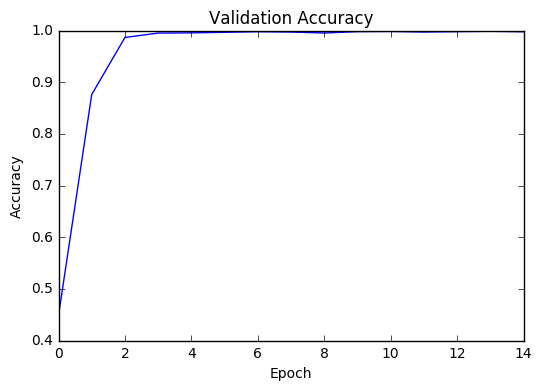

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(validation_accuracy_history)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')   

Model restored.
Test Accuracy: 0.9781473094946981
F1 score: 0.977976396949551


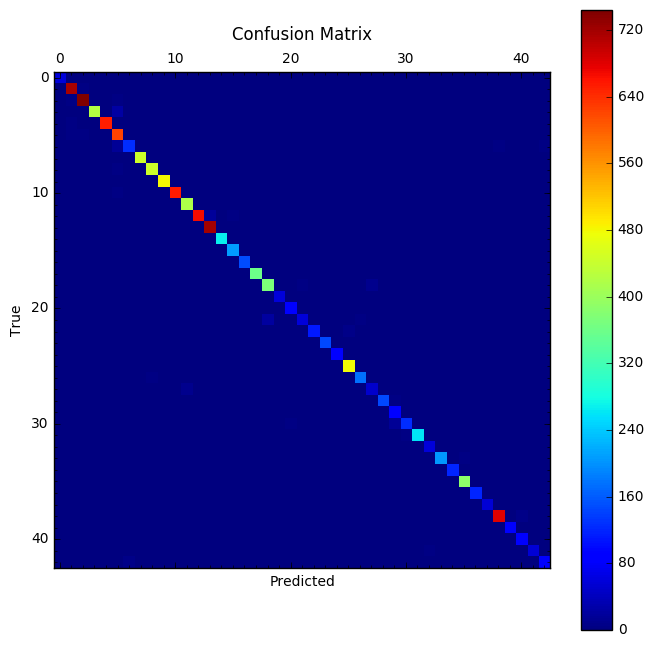

In [207]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# TEST SET
# Get Accuracy
with tf.Session() as sess:
    # Restore session from disk.
    saver.restore(sess, './' + save_file_name)
    print("Model restored.")   
    test_accuracy = 0.
    predicted_classes = []
    n_test_batches = math.ceil(get_num_test_samples() / 3000)
    for i in range(n_test_batches):
        test_batch_features, test_batch_labels = get_next_test_batch(3000)
        curr_accuracy, curr_pred = sess.run([accuracy, y_pred],
                                            feed_dict={x: test_batch_features, y: test_batch_labels, keep_prob: 1.0})
        test_accuracy += curr_accuracy * (len(test_batch_features) / get_num_test_samples())
        predicted_classes.extend(curr_pred)
    print('Test Accuracy: {}'.format(test_accuracy))
    print('F1 score: {}'.format(f1_score(y_true=get_test_classes(), y_pred=predicted_classes, average="weighted")))
    
    # Create confusion matrix
    c = confusion_matrix(y_true=get_test_classes(), y_pred=predicted_classes)
    n_classes = len(set(get_test_classes()))
    fig, ax = plt.subplots(figsize=(8, 8))
    cm = ax.matshow(c)
    fig.colorbar(cm)
    ax.set_xticks(np.arange(n_classes), range(n_classes))
    ax.set_yticks(np.arange(n_classes), range(n_classes))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')    
    ax.set_title('Confusion Matrix')   
    plt.show()


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I used the Adam optimizer, which is an adaptative algorithm that uses momentum. I used it since it needs little tinkering with hyperparameters and it has been shown to work very well for stochastic gradient descent optimizations. For the learning rate, which is the only hyperparameter that the Adam opmitizer algorithm takes, I used 0.001, which I found to be a good value for fast convergence speed without overshooting good minima.
I used a batch size of 256 samples for training and 15 epochs. In each epoch I train the model with the entire training set and after each epoch I randomly shuffle the data set. I found that adding more epochs didn't improve the accuracy of the model.
<p>I tried to tune certain parameters of the model, like weights and bias initialization, kernel sizes and drop-out probability, but I found that they had little effect in the validation accuracy after a few epochs.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started by reading papers on traffic sign recognition and specially this paper "A Committee of Neural Networks for Traffic Sign Classification" caught my attention. Based on the ideas of that paper, I implemented contrast equalization using CLAHE, data augmentation and the convolutional neural network as explained before. I favored the approach of using a deeper convolutional network whose consecutive convolutional layers are able to extract features of increasing complexity, from low-level to high-level. These networks are shown to perform better than shallow ones on image classification problems. The particular proposed network architecture was empirically shown to perform better than LeNet-5 on the traffic sign classification task. 
<p>Since the CNN architecture of that paper was already proven to work well (although with different image sizes), I left untouched the overall layer design and I adapted it to the image sizes of the provided datasets. I also modified  the kernel sizes by trial and error as well as trying to improve regularization by adding drop-out nodes in multiple locations of the model. The final architecture is the best compromise I've found between classification perfomance on one hand and memory usage and training time on the other.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [65]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import os
import cv2
import csv
import matplotlib.pyplot as plt
import math

# Visualizations will be shown in the notebook.
%matplotlib inline

signnames_file = "signnames.csv"
new_images_dir = "./new_images/"

def show_new_images(images, image_classes, signnames):
    n_images = len(image_classes)
    cols = 5
    rows = math.ceil(n_images/cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4))

    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, image in enumerate(images):
        ax = axes.flat[i]
        ax.imshow(image)
        img_class = image_classes[i]
        ax.set_xlabel("{}-{}".format(img_class, signnames[img_class]), fontsize='x-small')

    for ax in axes.flat:
        if ax.get_xlabel():
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)
            
    plt.show()

    
def get_signnames(signnames_file):
    signnames = []
    with open(signnames_file, mode='r') as f:        
        reader = csv.DictReader(f, delimiter=',')
        for row in reader:
            signnames.append(row['SignName'])
    return signnames

def get_new_image(file_name):
    img = cv2.imread(file_name)
    n = min(img.shape[:2])
    # Crop the largest dimension to make it square and resize
    img = cv2.resize(img[:n,:n], (32, 32), interpolation=cv2.INTER_AREA)
    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_new_image_class(file_name):
    base_name = os.path.basename(file_name)           
    class_label = int(base_name.split("_")[0])
    return class_label

def get_new_images(img_dir):
    new_image_paths = glob.glob(os.path.join(img_dir, "*.jpg"))    
    X_new = []
    y_new_classes = []
    print("Loading images..." )
    for img_path in new_image_paths:
        print(img_path)
        X_new.append(get_new_image(img_path))
        y_new_classes.append(get_new_image_class(img_path))
    print("{} images loaded".format(len(X_new)))
    X_new = np.array(X_new, np.uint8)
    y_new_classes = np.array(y_new_classes, np.uint8)
    return X_new, y_new_classes

X_new, y_new_classes = get_new_images(new_images_dir)

Loading images...
./new_images/11_RightOfWay.jpg
./new_images/21_DoubleCurve1.jpg
./new_images/1_SpeedLimit30.jpg
./new_images/17_NoEntry.jpg
./new_images/41_EndNoPassing.jpg
5 images loaded


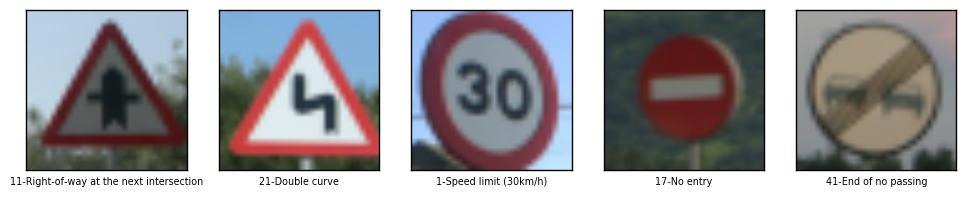

In [66]:
signnames = get_signnames(signnames_file)
show_new_images(X_new, y_new_classes, signnames)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I have selected 5 images from a dataset of Spanih traffic signs (Traffic Signs UAH Dataset). 
<p>Skewed images could make classification a bit more difficult. The  the model trained with an augmented dataset should provide some degree of transformattion invariance. Those signs that have similar pairs, like "double curve" or speed limits, or "End of no passing" can be more challenging to clasiffy, but with good lighting as they have they should be classified correctly. The "End of no passing" sign might be the most difficult to classify because there are other similar signs whose differences have lower contrast.

In [67]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
from sklearn.preprocessing import LabelBinarizer

X_new_orig = X_new[:]
X_new = pre_process_images(X_new)
one_hot_encoder = LabelBinarizer()
one_hot_encoder.fit(y_train)
y_new = one_hot_encoder.transform(y_new_classes).astype(np.float32)


In [68]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, './' + save_file_name)
    predicted_classes, new_set_accuracy = sess.run([y_pred, accuracy], feed_dict = {x: X_new, y: y_new, keep_prob: 1.0})

Accuracy on new image set: 1.0000


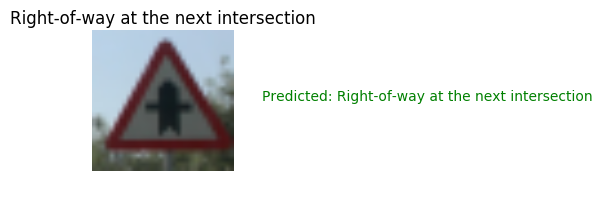

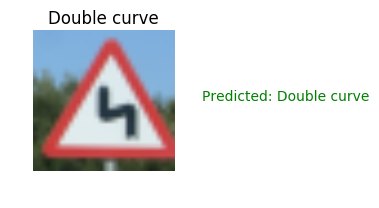

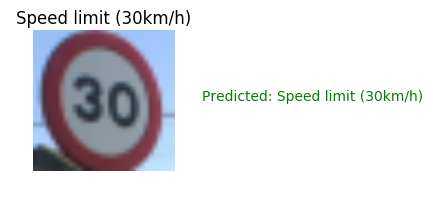

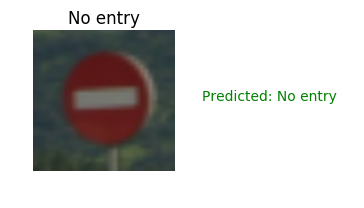

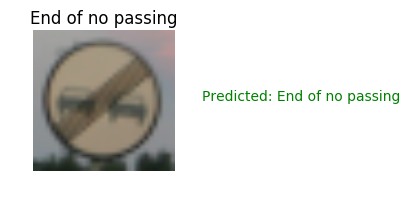

In [69]:
print("Accuracy on new image set: {:.4f}".format(new_set_accuracy))

for i, img in enumerate(X_new_orig):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(4,2))
    ax1.imshow(img)
    ax1.set_title(signnames[y_new_classes[i]])
    ax1.axis('off')
    if predicted_classes[i] == y_new_classes[i]:
        color = 'g'
    else:
        color = 'r'
    ax2.text(0, 0.5, 'Predicted: ' + str(signnames[predicted_classes[i]]), color=color)
    ax2.axis('off')
    plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
My model is able to correctly predict all of the signs.

In [70]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, './' + save_file_name)

    y_prob = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(y_prob, k=5)
    top_values, top_indices = sess.run([top_k_val, top_k_idx], feed_dict = {x: X_new, y: y_new, keep_prob: 1.0})

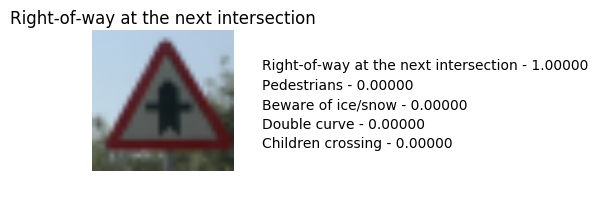

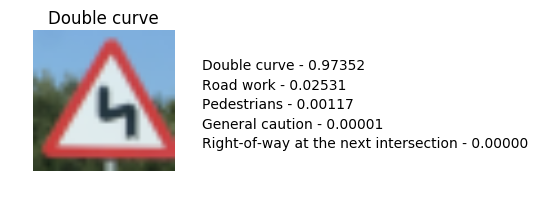

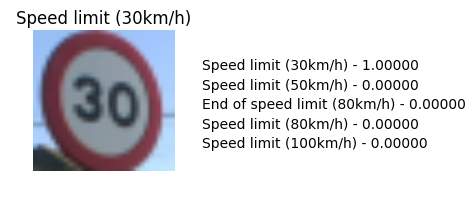

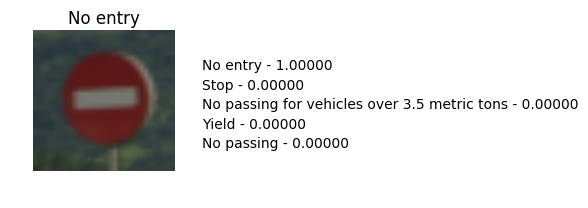

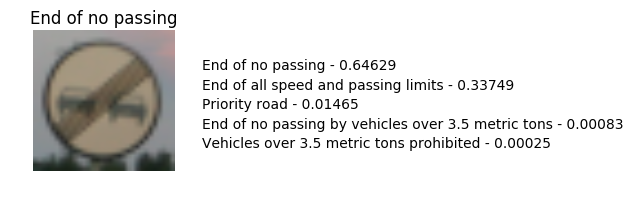

In [71]:
for i, img in enumerate(X_new_orig):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(4,2))
    ax1.imshow(img)
    ax1.set_title(signnames[y_new_classes[i]])
    ax1.axis('off')
    for j, index in enumerate(top_indices[i]):
        ax2.text(0, 0.7-j/8, signnames[index] + ' - {:.5f}'.format((top_values[i][j])))
    ax2.axis('off')
    plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.